In [1]:
import os
os.chdir('/data/users/dschnelb/mlpolicylab_fall20_schools2/src')

In [98]:
import pandas as pd

from load_data import get_graduation_info, connect_cursor, no_ninth_grade
from configloader import load_config, create_data_from_loaders

In [71]:
loaders, labeler, splitter, preprocessor, imputer, model = load_config(
           '/data/users/dschnelb/mlpolicylab_fall20_schools2/configs/rf_baseline_local.yaml')

In [127]:
cur = connect_cursor('/data/users/dschnelb/secrets.yaml')
df = get_graduation_info(cur)
grad_info_cols = df.columns

df['student_lookup'] = df['student_lookup'].astype(int)
df = df.set_index('student_lookup')
assert df.index.is_unique
loaded_df = create_data_from_loaders(loaders, cur)
assert loaded_df.index.is_unique
df = df.join(loaded_df)

In [7]:
df.head()

,entry_year,grad_year,dropout_year,in_state_transfer_year,transfer_out_year,withdrew_year,grade_12_entry_year,grade_12_withdraw_reason,rnum,absent_grade_5_absence_excused,...,ogt_science_pl_Basic,ogt_science_pl_Limited,ogt_science_pl_Proficient,ogt_science_missing,ogt_socstudies_pl_Accelerated,ogt_socstudies_pl_Advanced,ogt_socstudies_pl_Basic,ogt_socstudies_pl_Limited,ogt_socstudies_pl_Proficient,ogt_socstudies_missing
student_lookup,,,,,,,,,,,,,,,,,,,,,
46,2012,NaN,2015.0,NaN,NaN,NaN,2015.0,did not withdraw,1,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47,2013,NaN,NaN,2015.0,NaN,NaN,2015.0,transferred - in state,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48,2012,NaN,NaN,NaN,NaN,NaN,NaN,None,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
49,2013,2015.0,NaN,NaN,NaN,NaN,2015.0,graduate,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
50,2013,2015.0,NaN,NaN,NaN,NaN,2015.0,graduate,1,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [97]:
df.groupby('entry_year', dropna=False).size()

entry_year
2007    1132
2008    1223
2009    1160
2010    1184
2011    1303
2012    2291
2013    2492
dtype: int64

In [9]:
yrs = sorted(list(df.entry_year.unique()))

[2007, 2008, 2009, 2010, 2011, 2012, 2013]

In [73]:
missing = pd.DataFrame()
for yr in yrs:
    s = df[df.entry_year == yr].isna().sum()/len(df[df.entry_year == yr])
    col=str(yr)
    missing[col]=s

In [74]:
missing

,2007,2008,2009,2010,2011,2012,2013
entry_year,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
grad_year,0.180212,0.185609,0.182759,0.177365,0.196470,0.282409,0.514446
dropout_year,0.981449,0.977923,0.974138,0.972128,0.980046,0.962462,0.985955
in_state_transfer_year,0.854240,0.776778,0.780172,0.766047,0.753645,0.829769,0.847111
transfer_out_year,0.985866,0.968929,0.975000,0.977196,0.974674,0.982540,0.982745
...,...,...,...,...,...,...,...
ogt_socstudies_pl_Advanced,0.119258,0.014718,0.023276,0.015203,0.021489,0.017896,0.072231
ogt_socstudies_pl_Basic,0.119258,0.014718,0.023276,0.015203,0.021489,0.017896,0.072231
ogt_socstudies_pl_Limited,0.119258,0.014718,0.023276,0.015203,0.021489,0.017896,0.072231
ogt_socstudies_pl_Proficient,0.119258,0.014718,0.023276,0.015203,0.021489,0.017896,0.072231


In [109]:
qry = 'select student_lookup, district from clean.all_snapshots where grade =10;'
cur.execute(qry)

rows = cur.fetchall()

district = pd.DataFrame(rows, columns=[name[0] for name in cur.description])

district['student_lookup'] = district['student_lookup'].astype('int')

In [111]:
df2 = pd.merge(df, district, on='student_lookup',how="left")

In [113]:
dists = sorted(list(df2.district.unique()))

In [114]:
dists

['Coshocton',
 'Crooksville',
 'East Muskingum',
 'Franklin',
 'Logan_Hocking',
 'Maysville',
 'Morgan',
 'New Lexington City SD',
 'Northern Local SD',
 'Ridgewood',
 'Riverview',
 'TriValley',
 'West Muskingum',
 'Zanesville']

In [138]:
lst = []
for d in dists:
    data = df2[df2.district==d]
    missing = pd.DataFrame()
    for yr in yrs:
        s = data[data.entry_year == yr].isna().sum()/len(data[data.entry_year == yr])
        col=str(yr)
        missing[col]=s
    lst.append(missing)

In [139]:
for i in range(0,14):
    lst[i].columns= pd.MultiIndex.from_product([[dists[i]], lst[i].columns])

In [142]:
missing_by_dist = pd.concat([lst[0], lst[1], lst[2], lst[3], lst[4], lst[5], lst[6], lst[7], lst[8],
 lst[9], lst[10], lst[11],lst[12],lst[13]], axis=1)

In [160]:
lst[2]

East Muskingum                             \
                                       2007 2008 2009   2010      2011   
student_lookup                          NaN  NaN  NaN  0.000  0.000000   
entry_year                              NaN  NaN  NaN  0.000  0.000000   
grad_year                               NaN  NaN  NaN  0.375  0.179191   
dropout_year                            NaN  NaN  NaN  1.000  0.965318   
in_state_transfer_year                  NaN  NaN  NaN  0.250  0.809249   
...                                     ...  ...  ...    ...       ...   
ogt_socstudies_pl_Basic                 NaN  NaN  NaN  0.000  0.017341   
ogt_socstudies_pl_Limited               NaN  NaN  NaN  0.000  0.017341   
ogt_socstudies_pl_Proficient            NaN  NaN  NaN  0.000  0.017341   
ogt_socstudies_missing                  NaN  NaN  NaN  0.000  0.017341   
district                                NaN  NaN  NaN  0.000  0.000000   

                                                  
                                  2012      2013  
student_lookup                0.000000  0.000000  
entry_year                    0.000000  0.000000  
grad_year                     0.190751  0.222222  
dropout_year                  0.971098  1.000000  
in_state_transfer_year        0.803468  0.811111  
...                                ...       ...  
ogt_socstudies_pl_Basic       0.017341  0.016667  
ogt_socstudies_pl_Limited     0.017341  0.016667  
ogt_socstudies_pl_Proficient  0.017341  0.016667  
ogt_socstudies_missing        0.017341  0.016667  
district                      0.000000  0.000000  

[1018 rows x 7 columns]

In [75]:
missing.to_csv('/data/users/dschnelb/mlpolicylab_fall20_schools2/eda/missing.csv')

In [161]:
missing_by_dist.to_csv('/data/users/dschnelb/mlpolicylab_fall20_schools2/eda/missing_by_dist.csv')

## Filtering for certain attributes

In [94]:
missing.filter(like='gpa', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
gpa_9,12.4,9.2,11.2,11.5,13.1,46.1,16.7
school_gpa_9_rank,0.0,0.0,0.0,0.0,0.0,0.0,0.0
school_gpa_9_decile,12.4,9.2,11.2,11.6,13.2,46.1,16.9


In [95]:
missing.filter(like='absent_grade_5', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
absent_grade_5_absence_excused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_5_absence_unexcused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_5_tardy_unexcused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_5_misc,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_5_absence_all_day,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_5_tardy_excused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_5_early_dismiss,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_5_early_dismiss_approved,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_5_pm_absent,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_5_CANNOT_FIND_CHECK_VALUES,99.8,100.0,99.5,51.1,56.3,62.9,65.9


In [96]:
missing.filter(like='absent_grade_6', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
absent_grade_6_absence_excused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_6_misc,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_6_absence_all_day,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_6_med_legal_all_day,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_6_school_transport_issue,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_6_tardy_unexcused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_6_field_trip,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_6_med_legal_am,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_6_early_dismiss,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_6_early_dismiss_approved,99.8,100.0,99.5,51.1,56.3,62.9,65.9


In [66]:
missing.filter(like='absent_grade_8', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
absent_grade_8_absence_excused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_8_suspension_educated,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_8_tardy_unexcused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_8_absence_unexcused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_8_early_dismiss_approved,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_8_suspension_in_school,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_8_misc,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_8_absence_all_day,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_8_early_dismiss,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_8_tardy_medical,99.8,100.0,99.5,51.1,56.3,62.9,65.9


In [65]:
missing.filter(like='absent_grade_9', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
absent_grade_9_absence_excused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_9_suspension_educated,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_9_tardy_unexcused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_9_absence_unexcused,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_9_suspension,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_9_early_dismiss,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_9_misc,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_9_left_early,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_9_med_legal_am,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_9_arrive_late_not_tardy,99.8,100.0,99.5,51.1,56.3,62.9,65.9


In [84]:
df[df.entry_year==2008]

,entry_year,grad_year,dropout_year,in_state_transfer_year,transfer_out_year,withdrew_year,grade_12_entry_year,grade_12_withdraw_reason,rnum,absent_grade_5_absence_excused,...,ogt_science_pl_Basic,ogt_science_pl_Limited,ogt_science_pl_Proficient,ogt_science_missing,ogt_socstudies_pl_Accelerated,ogt_socstudies_pl_Advanced,ogt_socstudies_pl_Basic,ogt_socstudies_pl_Limited,ogt_socstudies_pl_Proficient,ogt_socstudies_missing
student_lookup,,,,,,,,,,,,,,,,,,,,,
7924,2008,NaN,NaN,2009.0,NaN,NaN,2011.0,transferred - in state,1,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34330,2008,2010.0,NaN,NaN,NaN,NaN,2010.0,graduate,1,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34331,2008,2010.0,NaN,NaN,NaN,NaN,2010.0,graduate,1,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34332,2008,2010.0,NaN,NaN,NaN,NaN,2010.0,graduate,1,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34333,2008,2010.0,NaN,NaN,NaN,NaN,2010.0,graduate,1,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60819,2008,NaN,NaN,NaN,2008.0,NaN,NaN,None,1,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
60851,2008,NaN,NaN,2008.0,NaN,NaN,NaN,None,1,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60885,2008,NaN,NaN,2008.0,NaN,NaN,NaN,None,1,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [89]:
missing.filter(like='math_pl_', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
third_math_pl_99,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_math_pl_Accelerated,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_math_pl_Advanced,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_math_pl_Basic,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_math_pl_Limited,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_math_pl_Proficient,11.9,1.5,2.3,1.5,2.1,1.8,7.2
fourth_math_pl_99,11.9,1.5,2.3,1.5,2.1,1.8,7.2
fourth_math_pl_Accelerated,11.9,1.5,2.3,1.5,2.1,1.8,7.2
fourth_math_pl_Advanced,11.9,1.5,2.3,1.5,2.1,1.8,7.2
fourth_math_pl_Basic,11.9,1.5,2.3,1.5,2.1,1.8,7.2


In [90]:
missing.filter(like='read_pl_', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
third_read_pl_99,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_read_pl_Accelerated,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_read_pl_Advance,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_read_pl_Advanced,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_read_pl_Basic,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_read_pl_Limited,11.9,1.5,2.3,1.5,2.1,1.8,7.2
third_read_pl_Proficient,11.9,1.5,2.3,1.5,2.1,1.8,7.2
fourth_read_pl_99,11.9,1.5,2.3,1.5,2.1,1.8,7.2
fourth_read_pl_Accelerated,11.9,1.5,2.3,1.5,2.1,1.8,7.2
fourth_read_pl_Advanced,11.9,1.5,2.3,1.5,2.1,1.8,7.2


In [62]:
missing.filter(like='ogt', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
ogt_read_ss,31.4,8.8,9.0,7.9,8.7,8.3,18.1
ogt_math_ss,30.7,9.0,8.5,8.1,8.8,8.4,17.7
ogt_write_ss,31.0,8.9,8.6,8.2,9.1,8.2,18.2
ogt_science_ss,30.7,8.8,8.4,8.0,8.7,7.9,17.5
ogt_socstudies_ss,31.0,9.1,8.8,7.9,8.8,8.2,17.7
ogt_read_pl_99,11.9,1.5,2.3,1.5,2.1,1.8,7.2
ogt_read_pl_Accelerated,11.9,1.5,2.3,1.5,2.1,1.8,7.2
ogt_read_pl_Advanced,11.9,1.5,2.3,1.5,2.1,1.8,7.2
ogt_read_pl_Basic,11.9,1.5,2.3,1.5,2.1,1.8,7.2
ogt_read_pl_Limited,11.9,1.5,2.3,1.5,2.1,1.8,7.2


In [64]:
missing.filter(like='_ss', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
third_read_ss,100.0,100.0,100.0,32.0,30.9,41.8,25.0
third_math_ss,100.0,100.0,100.0,100.0,31.9,42.0,24.0
fourth_read_ss,26.0,26.1,28.2,26.4,27.5,16.9,21.3
fourth_math_ss,26.3,26.8,28.4,26.4,27.5,16.9,21.4
fourth_write_ss,28.2,26.9,28.4,26.4,27.6,16.9,21.3
fourth_ctz_ss,26.4,26.8,28.5,26.4,97.9,100.0,100.0
fourth_science_ss,26.3,26.8,28.5,26.4,97.9,100.0,100.0
fifth_read_ss,99.9,99.5,25.6,23.0,13.1,15.6,19.4
fifth_math_ss,100.0,100.0,99.9,24.6,13.2,15.6,19.3
fifth_socstudies_ss,100.0,100.0,100.0,100.0,14.8,15.6,19.5


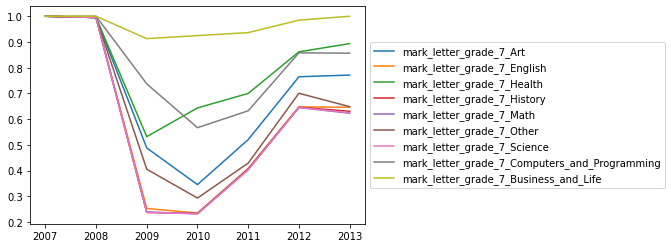

In [55]:
missing.filter(like='letter_grade_7', axis=0).T.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [67]:
missing.filter(like='letter_grade_9', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
mark_letter_grade_9_English,20.8,10.4,12.1,14.8,18.0,48.5,49.6
mark_letter_grade_9_Health,59.5,57.0,54.1,56.5,76.8,82.2,82.7
mark_letter_grade_9_History,42.4,29.8,32.7,34.5,36.7,58.4,56.1
mark_letter_grade_9_Math,21.1,14.8,16.5,16.3,16.2,47.5,48.2
mark_letter_grade_9_Other,25.0,13.7,15.8,15.0,18.0,48.9,50.6
mark_letter_grade_9_Science,20.6,11.1,14.3,13.1,15.6,48.0,51.8
mark_letter_grade_9_Business_and_Life,96.1,93.1,94.7,76.9,80.4,86.8,90.3
mark_letter_grade_9_Art,85.2,75.7,77.8,79.3,74.1,85.6,85.6
mark_letter_grade_9_Computers_and_Programming,94.8,95.9,93.6,96.1,95.5,96.8,97.7


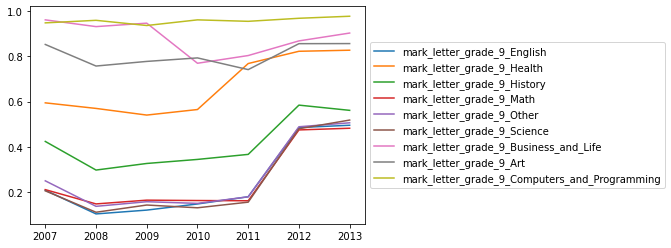

In [54]:
missing.filter(like='letter_grade_9', axis=0).T.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [77]:
missing.filter(regex='ethnicity|gender', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
ethnicity_A,0.0,0.0,0.0,0.1,0.0,10.9,2.6
ethnicity_B,0.0,0.0,0.0,0.1,0.0,10.9,2.6
ethnicity_H,0.0,0.0,0.0,0.1,0.0,10.9,2.6
ethnicity_I,0.0,0.0,0.0,0.1,0.0,10.9,2.6
ethnicity_M,0.0,0.0,0.0,0.1,0.0,10.9,2.6
ethnicity_W,0.0,0.0,0.0,0.1,0.0,10.9,2.6
ethnicity_missing,0.0,0.0,0.0,0.1,0.0,10.9,2.6
gender_F,0.0,0.0,0.0,0.1,0.0,10.9,2.6
gender_M,0.0,0.0,0.0,0.1,0.0,10.9,2.6
gender_missing,0.0,0.0,0.0,0.1,0.0,10.9,2.6


In [76]:
missing.filter(regex='zip', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
zip_25106,0.0,0.0,0.0,0.1,0.0,10.9,2.6
zip_28079,0.0,0.0,0.0,0.1,0.0,10.9,2.6
zip_33782,0.0,0.0,0.0,0.1,0.0,10.9,2.6
zip_33896,0.0,0.0,0.0,0.1,0.0,10.9,2.6
zip_34639,0.0,0.0,0.0,0.1,0.0,10.9,2.6
...,...,...,...,...,...,...,...
zip_45845,0.0,0.0,0.0,0.1,0.0,10.9,2.6
zip_48322,0.0,0.0,0.0,0.1,0.0,10.9,2.6
zip_82718,0.0,0.0,0.0,0.1,0.0,10.9,2.6
zip_83646,0.0,0.0,0.0,0.1,0.0,10.9,2.6


In [78]:
missing.filter(regex='disability', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
disability_autism_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
disability_autism_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
disability_autism_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
disability_cognitive_disability_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
disability_cognitive_disability_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
disability_cognitive_disability_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
disability_deaf_blind_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
disability_deaf_blind_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
disability_deaf_blind_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
disability_deafness_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3


In [79]:
missing.filter(regex='special_ed', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
special_ed_binary_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
special_ed_binary_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
special_ed_binary_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
special_ed_0_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
special_ed_0_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
special_ed_0_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
special_ed_100_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
special_ed_100_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
special_ed_100_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
special_ed_50_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3


In [85]:
missing.filter(regex='inv_', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
inv_group__grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
inv_group__grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
inv_group__grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
inv_group_academic_intracurr_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
inv_group_academic_intracurr_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
inv_group_academic_intracurr_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
inv_group_academic_inv_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
inv_group_academic_inv_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
inv_group_academic_inv_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
inv_group_atheletics_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3


In [86]:
missing.filter(regex='limited|gifted', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
gifted_N_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
gifted_N_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
gifted_N_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
gifted_Y_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
gifted_Y_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
gifted_Y_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
limited_english_M_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3
limited_english_M_grade_8,30.8,16.4,11.2,10.3,19.9,47.2,55.3
limited_english_M_grade_9,30.8,16.4,11.2,10.3,19.9,47.2,55.3
limited_english_N_grade_7,30.8,16.4,11.2,10.3,19.9,47.2,55.3


In [93]:
missing.filter(like='school_', axis=0).round(3)*100

,2007,2008,2009,2010,2011,2012,2013
absent_grade_6_school_transport_issue,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_9_school_transport_issue,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_8_school_transport_issue,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_7_school_transport_issue,99.8,100.0,99.5,51.1,56.3,62.9,65.9
absent_grade_5_suspension_in_school_binary,99.8,100.0,99.5,51.1,56.3,62.9,65.9
...,...,...,...,...,...,...,...
school_PHILO_HIGH_SCHOOL_grade_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
school_ZANESVILLE_CCFD_grade_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
school_ZANESVILLE_CCFD_grade_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
school_ZANESVILLE_CCFD_grade_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
